Network Analysis : Link Prediction with NetworkX  
Prepared by Alex Aw   
16 March 2023

<b>Table of Content</b><a name="toc"></a>   
1. [Objectives and Background](#objective)   
2. [EDA & Preprocessing](#eda)   
	2.1 [Visualisation](#visual)   
	2.2 [Further Pre-processing](#furtherprep)   
3. [Centrality Features](#cenfeat)   
	3.1 [Building the features](#buildfeat)   
	3.2 [Building the classification model](#buildmode)   
4. [In-Built Algorithm](#inbalgo)   
	4.1 [Jaccard Coefficient](#jaccard)   
	4.2 [Adamic-Adar](#adamic)   
	4.3 [Preferential Attachment](#prefatt)   
	4.4 [Plotting the results](#plotting)   
5.  [Afterthought](#aftertot)  
	5.1 [Which Algo?](#whichalgo)   
	5.2 [What's next?](#whatnext)    

## Objectives and Background <a name="objective"></a>

To practise Network Analysis using [The Marvel Universe Social Network](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network/code?select=hero-network.csv) data. Following some of fellow contributors data preprocessing to gain an understanding how to work with network graph data. The notebooks in Marvel showed good network analysis but did not apply Link Prediction. 

Using references from other sites and examples, this notebook is an attempt to apply Link Prediction. 2 methods have been found using NetworkX to generate the features or in-built algorithm to do the link predictions. The first uses NetworkX to generate different features based on centrality and then proceed to use classifying algorithm to predict the outcome [1]. The second uses NetworkX built in algorithm such as Jaccard Coefficient, Adamic-Adar and Prederential Attachment to predict the outcome [2]. So I'll try both methods and see the result and analyse the performances.

A third and possible alternative would be to consider using Graph Neural Network (GNN). To attempt GNN, I'd use the same dataset but on another notebook. 

[1] [NetworkX Link Prediction](https://www.kaggle.com/code/mastmustu/networkx-link-prediction)   
[2] [Graph Learning](https://maelfabien.github.io/machinelearning/graph_4/)


In [1]:
'''
There is version conflict between networkx and scipy. Error arose when trying to draw the graph or calculate the centrality.
"AttributeError: module 'scipy.sparse' has no attribute 'coo_array'"

After checking online and testing several version mix, scipy latest version (as of writing) 1.10.1 and 
networkx version 2.6.3 worked for me.
'''
# !pip install scipy==1.10.1
# !pip install networkx==2.6.3

'\nThere is version conflict between networkx and scipy. Error arose when trying to draw the graph or calculate the centrality.\n"AttributeError: module \'scipy.sparse\' has no attribute \'coo_array\'"\n\nAfter checking online and testing several version mix, scipy latest version (as of writing) 1.10.1 and \nnetworkx version 2.6.3 worked for me.\n'

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 
from IPython.display import display, Image
from PIL import Image
import seaborn as sns
import itertools
import pickle
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, accuracy_score

from lightgbm import LGBMClassifier

In [3]:
df_edge = pd.read_csv('data/edges.csv') # Edges
df_hero = pd.read_csv('data/hero-network.csv') # Hero
df_node = pd.read_csv('data/nodes.csv') # Nodes

[Top](#toc)

## EDA & Preprocessing <a name="eda"></a>

In [4]:
print(df_edge.head(10))
print(df_hero.head(10))
print(df_node.head(10))

                   hero     comic
0  24-HOUR MAN/EMMANUEL    AA2 35
1  3-D MAN/CHARLES CHAN     AVF 4
2  3-D MAN/CHARLES CHAN     AVF 5
3  3-D MAN/CHARLES CHAN     COC 1
4  3-D MAN/CHARLES CHAN    H2 251
5  3-D MAN/CHARLES CHAN    H2 252
6  3-D MAN/CHARLES CHAN  M/PRM 35
7  3-D MAN/CHARLES CHAN  M/PRM 36
8  3-D MAN/CHARLES CHAN  M/PRM 37
9  3-D MAN/CHARLES CHAN     WI? 9
                  hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL
5  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
6  STEELE, SIMON/WOLFGA      FORTUNE, DOMINIC
7  STEELE, SIMON/WOLFGA   ERWIN, CLYTEMNESTRA
8  STEELE, SIMON/WOLFGA  IRON MAN/TONY STARK 
9  STEELE, SIMON/WOLFGA  IRON MAN IV/JAMES R.
                   node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  co

Cleaning up the text by limiting text character to 20 and split on "/" since the text after / is name of the hero.

In [5]:
for c in ['hero1', 'hero2']:
    print(f"{c} name max in hero-network.csv : {max(df_hero[c].apply(lambda x : len(x)))}")
    

# Name Preprocessing
## only use len 20 & only use left string bas on "/"
for c in ['hero1', 'hero2']:
    df_hero[c] = df_hero[c].apply(lambda x : x[:20].split("/")[0])
df_edge['hero'] = df_edge['hero'].apply(lambda x : x[:20].split("/")[0])
df_node['node'] = df_node['node'].apply(lambda x : x[:20].split("/")[0])

print(100*"*")
print(df_edge.head(10))
print(df_hero.head(10))
print(df_node.head(10))

hero1 name max in hero-network.csv : 20
hero2 name max in hero-network.csv : 20
****************************************************************************************************
          hero     comic
0  24-HOUR MAN    AA2 35
1      3-D MAN     AVF 4
2      3-D MAN     AVF 5
3      3-D MAN     COC 1
4      3-D MAN    H2 251
5      3-D MAN    H2 252
6      3-D MAN  M/PRM 35
7      3-D MAN  M/PRM 36
8      3-D MAN  M/PRM 37
9      3-D MAN     WI? 9
           hero1                hero2
0  LITTLE, ABNER       PRINCESS ZANDA
1  LITTLE, ABNER        BLACK PANTHER
2  BLACK PANTHER       PRINCESS ZANDA
3  LITTLE, ABNER       PRINCESS ZANDA
4  LITTLE, ABNER        BLACK PANTHER
5  BLACK PANTHER       PRINCESS ZANDA
6  STEELE, SIMON     FORTUNE, DOMINIC
7  STEELE, SIMON  ERWIN, CLYTEMNESTRA
8  STEELE, SIMON             IRON MAN
9  STEELE, SIMON          IRON MAN IV
          node   type
0      2001 10  comic
1       2001 8  comic
2       2001 9  comic
3  24-HOUR MAN   hero
4      3-D MAN  

In hero-network data, hero1 & hero2 have different values.

In [6]:
print(df_hero[df_hero['hero1']=="CAPTAIN AMERICA"].count())

print(df_hero[df_hero['hero2']=="CAPTAIN AMERICA"].count())

hero1    8149
hero2    8149
dtype: int64
hero1    8350
hero2    8350
dtype: int64


In [7]:
top20_hero = df_hero["hero1"].value_counts().head(20)

top20_hero

CAPTAIN AMERICA    8149
SPIDER-MAN         6652
IRON MAN           5850
THOR               5712
THING              5369
WOLVERINE          5230
SCARLET WITCH      5184
VISION             5067
HUMAN TORCH        4970
MR. FANTASTIC      4788
INVISIBLE WOMAN    4723
BEAST              4628
HAWK               4506
CYCLOPS            4492
WASP               4452
STORM              4170
COLOSSUS II        3997
PROFESSOR X        3973
ANT-MAN            3727
MARVEL GIRL        3667
Name: hero1, dtype: int64

[Top](#toc)

### Visualisation <a name="visual"></a>

Creating a 1% sample of the 8 more well known and popular heroes.

In [8]:
thor = df_hero[df_hero['hero1']=="THOR"].sample(frac=0.01, random_state=42)
ironman = df_hero[df_hero['hero1']=="IRON MAN"].sample(frac=0.01, random_state=42)
spider = df_hero[df_hero['hero1']=="SPIDER-MAN"].sample(frac=0.01, random_state=42)
capt = df_hero[df_hero['hero1']=="CAPTAIN AMERICA"].sample(frac=0.01, random_state=42)
hulk = df_hero[df_hero['hero1']=="HULK"].sample(frac=0.01, random_state=42)
storm = df_hero[df_hero['hero1']=="STORM"].sample(frac=0.01, random_state=42)
wolverine = df_hero[df_hero['hero1']=="WOLVERINE"].sample(frac=0.01, random_state=42)
strange = df_hero[df_hero['hero1']=="DR. STRANGE"].sample(frac=0.01, random_state=42)

In [9]:
samplehero = pd.concat([thor,ironman,spider,capt,hulk,storm,wolverine,strange],axis = 0)
samplehero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 152238 to 69526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero1   422 non-null    object
 1   hero2   422 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


Distribution of heroes in column hero1

<AxesSubplot:xlabel='hero1', ylabel='Count'>

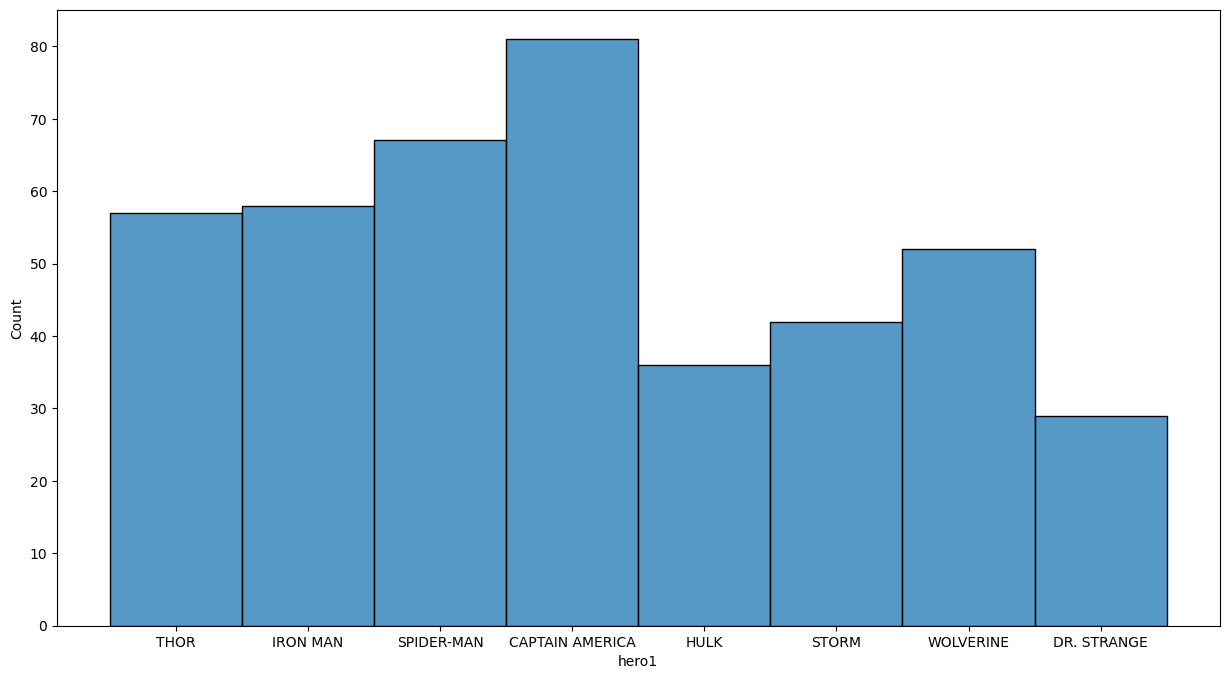

In [10]:
plt.figure(figsize = (15,8))
sns.histplot(data=samplehero["hero1"])

In [11]:
samplehero["hero2"].value_counts()

ANT-MAN             8
SCARLET WITCH       8
HUMAN TORCH         7
IRON MAN            6
CAPTAIN AMERICA     5
                   ..
HOPKINS, STEVE      1
CHAMELEON           1
TALISMAN II         1
ROBERTSON, RANDY    1
CLEA                1
Name: hero2, Length: 261, dtype: int64

Distribution of heroes in column hero2

In [12]:
plt.figure(figsize = (15,8))
sns.histplot(data=samplehero["hero2"])

<AxesSubplot:xlabel='hero2', ylabel='Count'>

A simple network graph based on the 1% sample of the popular heroes. 

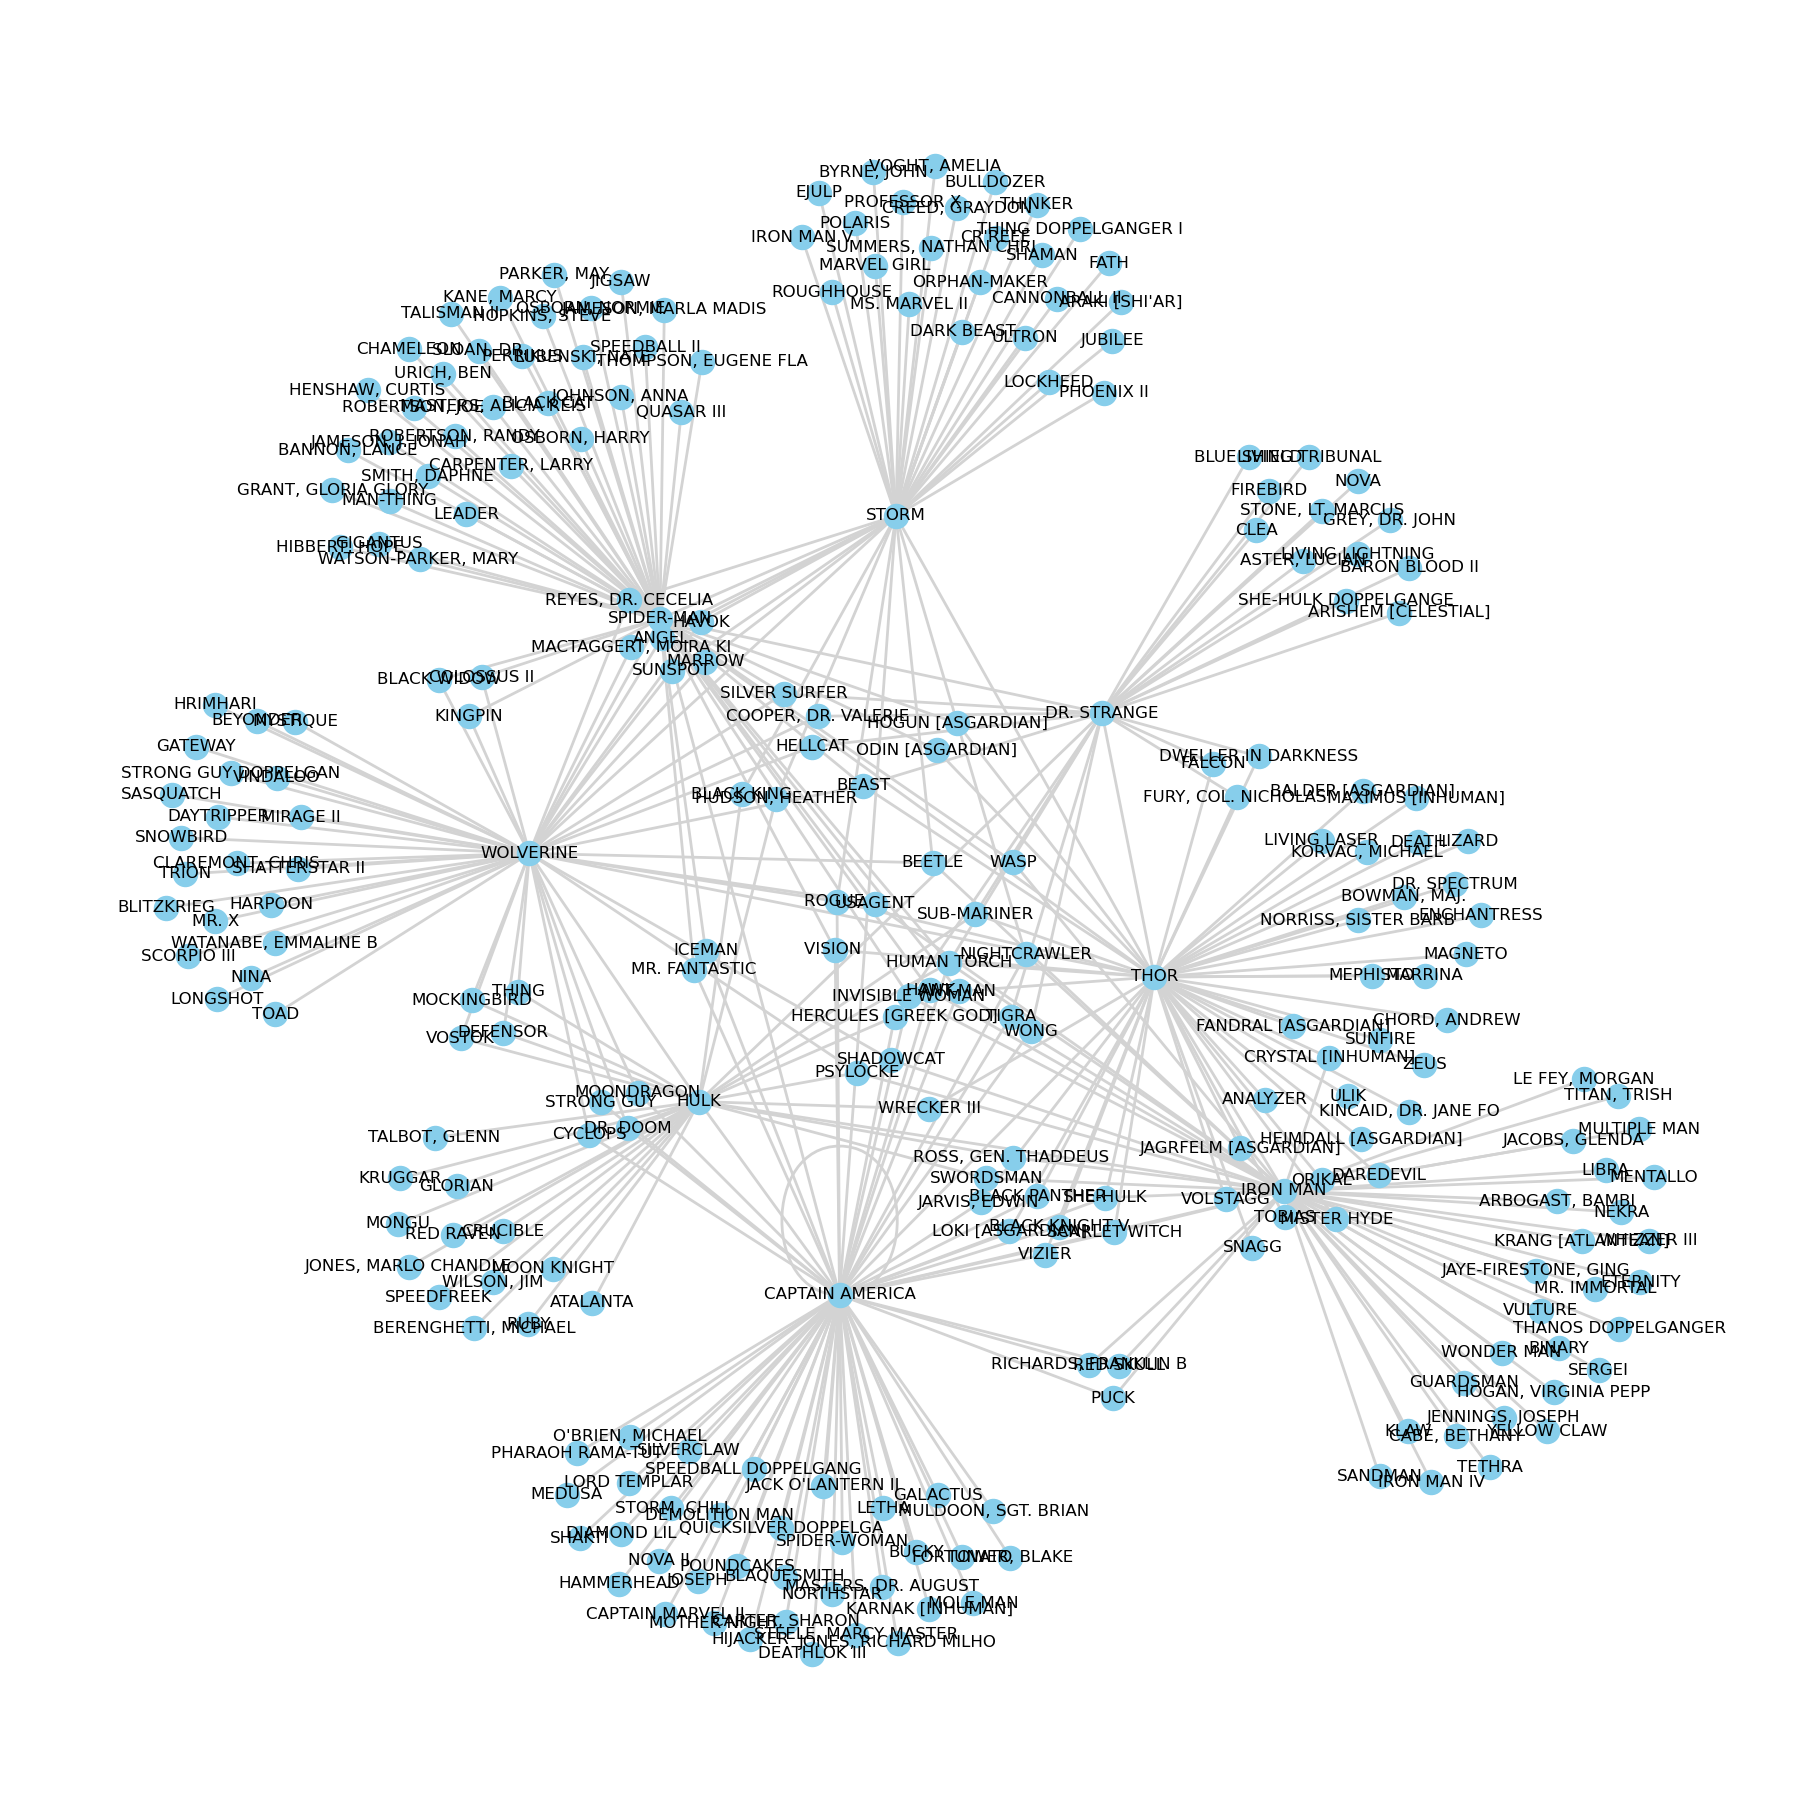

In [13]:
G = nx.from_pandas_edgelist(samplehero, 'hero1', 'hero2')
pos = nx.spring_layout(G, seed=9666)
options = {
    "node_color": "skyblue",
    "edge_color": "lightgrey",
    "width": 2,
    "edge_cmap": plt.cm.Blues,
    "with_labels": True
#     "alpha": 0.5
}
plt.figure(figsize = (18,18))
nx.draw(G, **options)
plt.show()

[Top](#toc)

### Further Pre-processing <a name="furtherprep"></a>

Full sample from the 8 popular heroes.

In [14]:
thor = df_hero[df_hero['hero1']=="THOR"]
ironman = df_hero[df_hero['hero1']=="IRON MAN"]
spider = df_hero[df_hero['hero1']=="SPIDER-MAN"]
capt = df_hero[df_hero['hero1']=="CAPTAIN AMERICA"]
hulk = df_hero[df_hero['hero1']=="HULK"]
storm = df_hero[df_hero['hero1']=="STORM"]
wolverine = df_hero[df_hero['hero1']=="WOLVERINE"]
strange = df_hero[df_hero['hero1']=="DR. STRANGE"]

samp_pophero = pd.concat([thor,ironman,spider,capt,hulk,storm,wolverine,strange],axis = 0)
samp_pophero.reset_index(inplace=True, drop=True)

samp_pophero.head(10)

hero1                hero2
0  THOR  GRANT, GLORIA GLORY
1  THOR     FAIRMONT, HANNAH
2  THOR          PARKER, MAY
3  THOR    JAMESON, J. JONAH
4  THOR     MCCORMICK, BARRY
5  THOR           SPIDER-MAN
6  THOR              TOKKOTS
7  THOR      SOUTHERN, CANDY
8  THOR                 WASP
9  THOR                ANGEL

The duplicates here can be used to calculate the weights of the edges. 

In [15]:
print("Total number of links :", len(samp_pophero))
print("Number of duplicates : ", samp_pophero.duplicated().sum())
print("Numer of unique links: ", len(samp_pophero[['hero1', 'hero2']].drop_duplicates()))

Total number of links : 42326
Number of duplicates :  34150
Numer of unique links:  8176


Further prepping sample dataset to consist of link(1) and nolink(0) feature to enable classification modelling.The dataset currently have edges between heroes, and obviously nodes without edges are not represented. 

In [16]:
samp_pophero = samp_pophero.drop_duplicates()

In [17]:
herolist1 = list(samp_pophero["hero1"])
herolist2 = list(samp_pophero["hero2"])

set1 = set(herolist1)
set2 = set(herolist2)

herolist_uni = set2 - set1
herolist = list(list(set1) + list(herolist_uni))

print("Number of unique heroes : ", len(herolist))

Number of unique heroes :  3280


In [18]:
herolist[:20]

['THOR',
 'IRON MAN',
 'WOLVERINE',
 'DR. STRANGE',
 'STORM',
 'SPIDER-MAN',
 'CAPTAIN AMERICA',
 'HULK',
 'KONIEV, MRS.',
 'PUPPY',
 'FAYRELYTE STRONGHEAR',
 'FUGUE',
 'KARMA',
 'TERRAX II',
 'TAGAR',
 'REILLY, MAVIS',
 'ROGERS, CAPT. STEVEN',
 'MAKO',
 'NELSON, CANDACE',
 'LEVIATHAN II']

<b>Important note:</b>   
Having 3,280 heroes (nodes) means having 5,377,560 possible links (edges), resulting in massive increment in data that require analysis. Computational requirement increases with each additional node and may become impracticable moving forward.

In [19]:
pairs = list(itertools.combinations(herolist, 2))

df_sample = pd.DataFrame(pairs, columns=['hero1', 'hero2'])
df_sample["link"] = "0"

df_sample

hero1               hero2 link
0                        THOR            IRON MAN    0
1                        THOR           WOLVERINE    0
2                        THOR         DR. STRANGE    0
3                        THOR               STORM    0
4                        THOR          SPIDER-MAN    0
...                       ...                 ...  ...
5377555           MODULAR MAN  HARDERMAN, QUENTIN    0
5377556           MODULAR MAN             ARAGORN    0
5377557  DORMA II [ATLANTEAN]  HARDERMAN, QUENTIN    0
5377558  DORMA II [ATLANTEAN]             ARAGORN    0
5377559    HARDERMAN, QUENTIN             ARAGORN    0

[5377560 rows x 3 columns]

In [20]:
df_sample[20000:20020]

hero1                hero2 link
20000  CAPTAIN AMERICA      RUDOLFO, PRINCE    0
20001  CAPTAIN AMERICA           TORK, SGT.    0
20002  CAPTAIN AMERICA                ARIZE    0
20003  CAPTAIN AMERICA  ELLENTHORPE, MARIAH    0
20004  CAPTAIN AMERICA        SHOOTING STAR    0
20005  CAPTAIN AMERICA              DARKOTH    0
20006  CAPTAIN AMERICA     PETROVITCH, IVAN    0
20007  CAPTAIN AMERICA            SPYMASTER    0
20008  CAPTAIN AMERICA              PIRANHA    0
20009  CAPTAIN AMERICA                 AJAX    0
20010  CAPTAIN AMERICA             MALICE V    0
20011  CAPTAIN AMERICA     LANG, DR. STEVEN    0
20012  CAPTAIN AMERICA                NANNY    0
20013  CAPTAIN AMERICA              BELASCO    0
20014  CAPTAIN AMERICA          YUAN, ANNIE    0
20015  CAPTAIN AMERICA       GAMBLE, GRACIE    0
20016  CAPTAIN AMERICA      DRAKE, FRANKLIN    0
20017  CAPTAIN AMERICA         MOONSTONE II    0
20018  CAPTAIN AMERICA               OX III    0
20019  CAPTAIN AMERICA            DISTORTER    0

In [21]:
%%time

# define function to apply to each row of df_sample
def check_rows(row):
    if (row['hero1'] in df_sample['hero1'].values) and (row['hero2'] in df_sample['hero2'].values):
        return "1"
    elif (row['hero1'] in df_sample['hero2'].values) and (row['hero2'] in df_sample['hero1'].values):
        return "1"
    else:
        return "0"

# apply function to each row of df_sample
df_sample['link'] = samp_pophero.apply(check_rows, axis=1)
df_sample["link"] = df_sample["link"].fillna(0)
df_sample['link'] = df_sample['link'].astype('int')
df_sample

CPU times: total: 15min 52s
Wall time: 15min 53s


hero1               hero2  link
0                        THOR            IRON MAN     1
1                        THOR           WOLVERINE     1
2                        THOR         DR. STRANGE     1
3                        THOR               STORM     1
4                        THOR          SPIDER-MAN     1
...                       ...                 ...   ...
5377555           MODULAR MAN  HARDERMAN, QUENTIN     0
5377556           MODULAR MAN             ARAGORN     0
5377557  DORMA II [ATLANTEAN]  HARDERMAN, QUENTIN     0
5377558  DORMA II [ATLANTEAN]             ARAGORN     0
5377559    HARDERMAN, QUENTIN             ARAGORN     0

[5377560 rows x 3 columns]

In [22]:
print("Total number of links : ", len(df_sample.loc[df_sample["link"]==1]))

Total number of links :  8176


In [23]:
# Saving sample df to pickle

df_sample.to_pickle("data/df_sample.pkl")

[Top](#toc)

## Centrality Features <a name="cenfeat"></a>
Using centrality to build features between the nodes to prepare a classifying model to predict the links.   
[NetworkX Link Prediction](https://www.kaggle.com/code/mastmustu/networkx-link-prediction)


In [24]:
df_sample = pd.read_pickle("data/df_sample.pkl")
df_sample

hero1               hero2  link
0                        THOR            IRON MAN     1
1                        THOR           WOLVERINE     1
2                        THOR         DR. STRANGE     1
3                        THOR               STORM     1
4                        THOR          SPIDER-MAN     1
...                       ...                 ...   ...
5377555           MODULAR MAN  HARDERMAN, QUENTIN     0
5377556           MODULAR MAN             ARAGORN     0
5377557  DORMA II [ATLANTEAN]  HARDERMAN, QUENTIN     0
5377558  DORMA II [ATLANTEAN]             ARAGORN     0
5377559    HARDERMAN, QUENTIN             ARAGORN     0

[5377560 rows x 3 columns]

In [25]:
unique_nodes = list(df_sample['hero1']) + list(df_sample["hero2"])
unique_nodes = list(set(unique_nodes))
len(unique_nodes)

3280

In [26]:
gx = nx.Graph()

In [27]:
gx.add_nodes_from(unique_nodes)

In [28]:
tuples_list = []
df_link  = df_sample[df_sample['link']==1]
for index, row in df_link.iterrows():
    source = row['hero1']
    target = row['hero2']
    
    tuples_list.append((source, target))
    
tuples_list[:10]

[('THOR', 'IRON MAN'),
 ('THOR', 'WOLVERINE'),
 ('THOR', 'DR. STRANGE'),
 ('THOR', 'STORM'),
 ('THOR', 'SPIDER-MAN'),
 ('THOR', 'CAPTAIN AMERICA'),
 ('THOR', 'HULK'),
 ('THOR', 'KONIEV, MRS.'),
 ('THOR', 'PUPPY'),
 ('THOR', 'FAYRELYTE STRONGHEAR')]

In [29]:
gx.add_edges_from(tuples_list)

[Top](#toc)

### Building the features <a name="buildfeat"></a>

In [30]:
%%time
pr_dict = nx.pagerank(gx)

CPU times: total: 31.2 ms
Wall time: 24 ms


In [31]:
%%time 
degree_list = nx.degree(gx)

CPU times: total: 0 ns
Wall time: 0 ns


In [32]:
%%time
degCent = nx.degree_centrality(gx)

CPU times: total: 0 ns
Wall time: 1 ms


In [33]:
%%time 
betCent = nx.betweenness_centrality(gx, normalized=True, endpoints=True, k = 50)

CPU times: total: 625 ms
Wall time: 614 ms


In [34]:
%%time 
hubs_dict, auth_dict = nx.hits(gx)

CPU times: total: 31.2 ms
Wall time: 31.9 ms


C:\Users\alex\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [35]:
degree_dict = {}

for x,y  in degree_list  :
    degree_dict[x] = y
    
len(degree_dict)

3280

In [36]:
%%time  
final_data_list = []
def transform_data(df, add_link = True) :
    
    for index, row in df.iterrows():
        src = row['hero1']
        tgt = row['hero2']
        
        data_list = []
        data_list.append(pr_dict[src])
        data_list.append(hubs_dict[src])
        data_list.append(degCent[src])
        data_list.append(betCent[src])
        data_list.append(pr_dict[tgt])
        data_list.append(hubs_dict[tgt])
        data_list.append(degCent[tgt])
        data_list.append(betCent[tgt])
        if add_link == True :
            data_list.append(row['link'])
        
        final_data_list.append(data_list)        
    if add_link == True :
        col_list = ['SrcPageRank','SrcHubs',
                    'SrcDegCnt','SrcBetCnt',
                    'TgtPageRank','TgtHubs',
                    'TgtDegCnt','TgtBetCnt',
                    'Link']
        df_centrality = pd.DataFrame(final_data_list, columns = col_list)        
    else :
        col_list = ['SrcPageRank','SrcHubs',
                    'SrcDegCnt','SrcBetCnt',
                    'TgtPageRank','TgtHubs',
                    'TgtDegCnt','TgtBetCnt',
                   ]
        df_centrality = pd.DataFrame(final_data_list, columns = col_list)        
    return df_centrality
              


CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
%%time
df_centrality = transform_data(df_sample)        
print(len(final_data_list))        
print(len(df_centrality))

5377560
5377560
CPU times: total: 3min 25s
Wall time: 3min 24s


In [38]:
df_centrality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5377560 entries, 0 to 5377559
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   SrcPageRank  float64
 1   SrcHubs      float64
 2   SrcDegCnt    float64
 3   SrcBetCnt    float64
 4   TgtPageRank  float64
 5   TgtHubs      float64
 6   TgtDegCnt    float64
 7   TgtBetCnt    float64
 8   Link         int64  
dtypes: float64(8), int64(1)
memory usage: 369.2 MB


Hubs & Auth perfect multicoliinearity. Other features also have very high correlation. 

In [39]:
df_centrality.corr()

SrcPageRank   SrcHubs  SrcDegCnt  SrcBetCnt  TgtPageRank  \
SrcPageRank     1.000000  0.945846   0.999922   0.920453     0.038528   
SrcHubs         0.945846  1.000000   0.947411   0.889109     0.036665   
SrcDegCnt       0.999922  0.947411   1.000000   0.921659     0.038480   
SrcBetCnt       0.920453  0.889109   0.921659   1.000000     0.035161   
TgtPageRank     0.038528  0.036665   0.038480   0.035161     1.000000   
TgtHubs         0.011301  0.012213   0.011320   0.010668     0.526165   
TgtDegCnt       0.037856  0.036155   0.037812   0.034561     0.997913   
TgtBetCnt       0.011062  0.011028   0.011063   0.010066     0.212376   
Link            0.447305  0.420566   0.447300   0.412409     0.035040   

              TgtHubs  TgtDegCnt  TgtBetCnt      Link  
SrcPageRank  0.011301   0.037856   0.011062  0.447305  
SrcHubs      0.012213   0.036155   0.011028  0.420566  
SrcDegCnt    0.011320   0.037812   0.011063  0.447300  
SrcBetCnt    0.010668   0.034561   0.010066  0.412409  
TgtPageRank  0.526165   0.997913   0.212376  0.035040  
TgtHubs      1.000000   0.577211   0.077373  0.026952  
TgtDegCnt    0.577211   1.000000   0.209274  0.035703  
TgtBetCnt    0.077373   0.209274   1.000000  0.007955  
Link         0.026952   0.035703   0.007955  1.000000

In [40]:
## Saving the centrality dataset

df_centrality.to_pickle("data/df_centrality.pkl")

[Top](#toc)

### Building the classification model <a name="buildmodel"></a>

In [41]:
df_centrality = pd.read_pickle("data/df_centrality.pkl")
df_centrality

SrcPageRank   SrcHubs  SrcDegCnt  SrcBetCnt  TgtPageRank   TgtHubs  \
0           0.038275  0.006957   0.211345   0.207317     0.033070  0.004224   
1           0.038275  0.006957   0.211345   0.207317     0.033583  0.005072   
2           0.038275  0.006957   0.211345   0.207317     0.043974  0.006169   
3           0.038275  0.006957   0.211345   0.207317     0.026150  0.003629   
4           0.038275  0.006957   0.211345   0.207317     0.042895  0.006121   
...              ...       ...        ...        ...          ...       ...   
5377555     0.000190  0.000298   0.000915   0.000386     0.000144  0.000193   
5377556     0.000190  0.000298   0.000915   0.000386     0.000048 -0.000000   
5377557     0.000096  0.000088   0.000305   0.000287     0.000144  0.000193   
5377558     0.000096  0.000088   0.000305   0.000287     0.000048 -0.000000   
5377559     0.000144  0.000193   0.000610   0.000316     0.000048 -0.000000   

         TgtDegCnt  TgtBetCnt  Link  
0         0.177798   0.091786     1  
1         0.185117   0.104626     1  
2         0.236962   0.093431     1  
3         0.144861   0.037111     1  
4         0.232083   0.091216     1  
...            ...        ...   ...  
5377555   0.000610   0.000316     0  
5377556   0.000000   0.000000     0  
5377557   0.000610   0.000316     0  
5377558   0.000000   0.000000     0  
5377559   0.000000   0.000000     0  

[5377560 rows x 9 columns]

In [42]:
X = df_centrality.drop('Link', axis =1)
y = df_centrality['Link']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 42) 
print(X_train.shape)
print(X_test.shape)

(3764292, 8)
(1613268, 8)


In [43]:
%%time
classifier = LGBMClassifier(
#             nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1 )

classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test) 

CPU times: total: 1h 29min 39s
Wall time: 8min 31s


In [44]:
%%time

train_acc = accuracy_score(y_train,y_train_pred)
test_acc = accuracy_score(y_test,y_test_pred)
print("Accuracy for Gradient Boost model for Train data {:.4f} %".format(train_acc*100))
print("Accuracy for Gradient Boost model for Test data {:.4f} %".format(test_acc*100))

Accuracy for Gradient Boost model for Train data 99.9233 %
Accuracy for Gradient Boost model for Test data 99.9076 %
CPU times: total: 328 ms
Wall time: 273 ms


In [45]:
%%time

print('Balanced accuracy for Gradient Boost Model for Train data {:.4f} %'.format(balanced_accuracy_score(y_train,y_train_pred)*100))
print('Balanced accuracy for Gradient Boost Model for Test data {:.4f} %'.format(balanced_accuracy_score(y_test,y_test_pred)*100))

Balanced accuracy for Gradient Boost Model for Train data 79.8042 %
Balanced accuracy for Gradient Boost Model for Test data 76.3992 %
CPU times: total: 609 ms
Wall time: 585 ms


In [46]:
train_cm = confusion_matrix(y_train,y_train_pred)
test_cm = confusion_matrix(y_test,y_test_pred)
print("Confusion Matrix for Gradient Boost model for Train data :\n" , train_cm)
print("Confusion Matrix for Gradient Boost model for Test data :\n" , test_cm)

Confusion Matrix for Gradient Boost model for Train data :
 [[3757958     551]
 [   2335    3448]]
Confusion Matrix for Gradient Boost model for Test data :
 [[1610514     361]
 [   1129    1264]]


In [47]:
print('Classification Report on Train Data\n',classification_report(y_train,y_train_pred))
print('Confusion Matrix on Train Data\n',confusion_matrix(y_train, y_train_pred))
print('\nClassification Report on Test Data\n',classification_report(y_test,y_test_pred))
print('Confusion Matrix on Test Data\n',confusion_matrix(y_test, y_test_pred))

Classification Report on Train Data
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   3758509
           1       0.86      0.60      0.70      5783

    accuracy                           1.00   3764292
   macro avg       0.93      0.80      0.85   3764292
weighted avg       1.00      1.00      1.00   3764292

Confusion Matrix on Train Data
 [[3757958     551]
 [   2335    3448]]

Classification Report on Test Data
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1610875
           1       0.78      0.53      0.63      2393

    accuracy                           1.00   1613268
   macro avg       0.89      0.76      0.81   1613268
weighted avg       1.00      1.00      1.00   1613268

Confusion Matrix on Test Data
 [[1610514     361]
 [   1129    1264]]


[Top](#toc)

## In-Built Algorithm <a name="inbalgo"></a>
Jaccard Coefficient, Adamic-Adar and Prederential Attachment   
[Graph Learning](https://maelfabien.github.io/machinelearning/graph_4/)

In [48]:
samp_pophero.head()

hero1                hero2
0  THOR  GRANT, GLORIA GLORY
1  THOR     FAIRMONT, HANNAH
2  THOR          PARKER, MAY
3  THOR    JAMESON, J. JONAH
4  THOR     MCCORMICK, BARRY

In [49]:
samp_pophero.reset_index(inplace=True, drop=True)
samp_pophero.info

<bound method DataFrame.info of             hero1                hero2
0            THOR  GRANT, GLORIA GLORY
1            THOR     FAIRMONT, HANNAH
2            THOR          PARKER, MAY
3            THOR    JAMESON, J. JONAH
4            THOR     MCCORMICK, BARRY
...           ...                  ...
8171  DR. STRANGE             CALLISTO
8172  DR. STRANGE                MAGMA
8173  DR. STRANGE               SUNDER
8174  DR. STRANGE           KULAN GATH
8175  DR. STRANGE  GYRICH, HENRY PETER

[8176 rows x 2 columns]>

In [50]:
Gb = nx.from_pandas_edgelist(samp_pophero, 'hero1', 'hero2')

In [51]:
n = Gb.number_of_nodes()
m = Gb.number_of_edges()
print("Number of nodes : %d" % n)
print("Number of edges : %d" % m)
print("Number of connected components : %d" % nx.number_connected_components(Gb))

Number of nodes : 3280
Number of edges : 8148
Number of connected components : 1


In [52]:
plt.figure(figsize=(18,18))
nx.draw(Gb)
plt.gca().collections[0].set_edgecolor("#000000")

In [53]:
# Remove 20% of the edges
random.seed(42)
proportion_edges = 0.2
edge_subset = random.sample(Gb.edges(), int(proportion_edges * Gb.number_of_edges()))

# Create a copy of the graph and remove the edges
Gb_train = Gb.copy()
Gb_train.remove_edges_from(edge_subset)

<a name="isolated-nodes"></a>

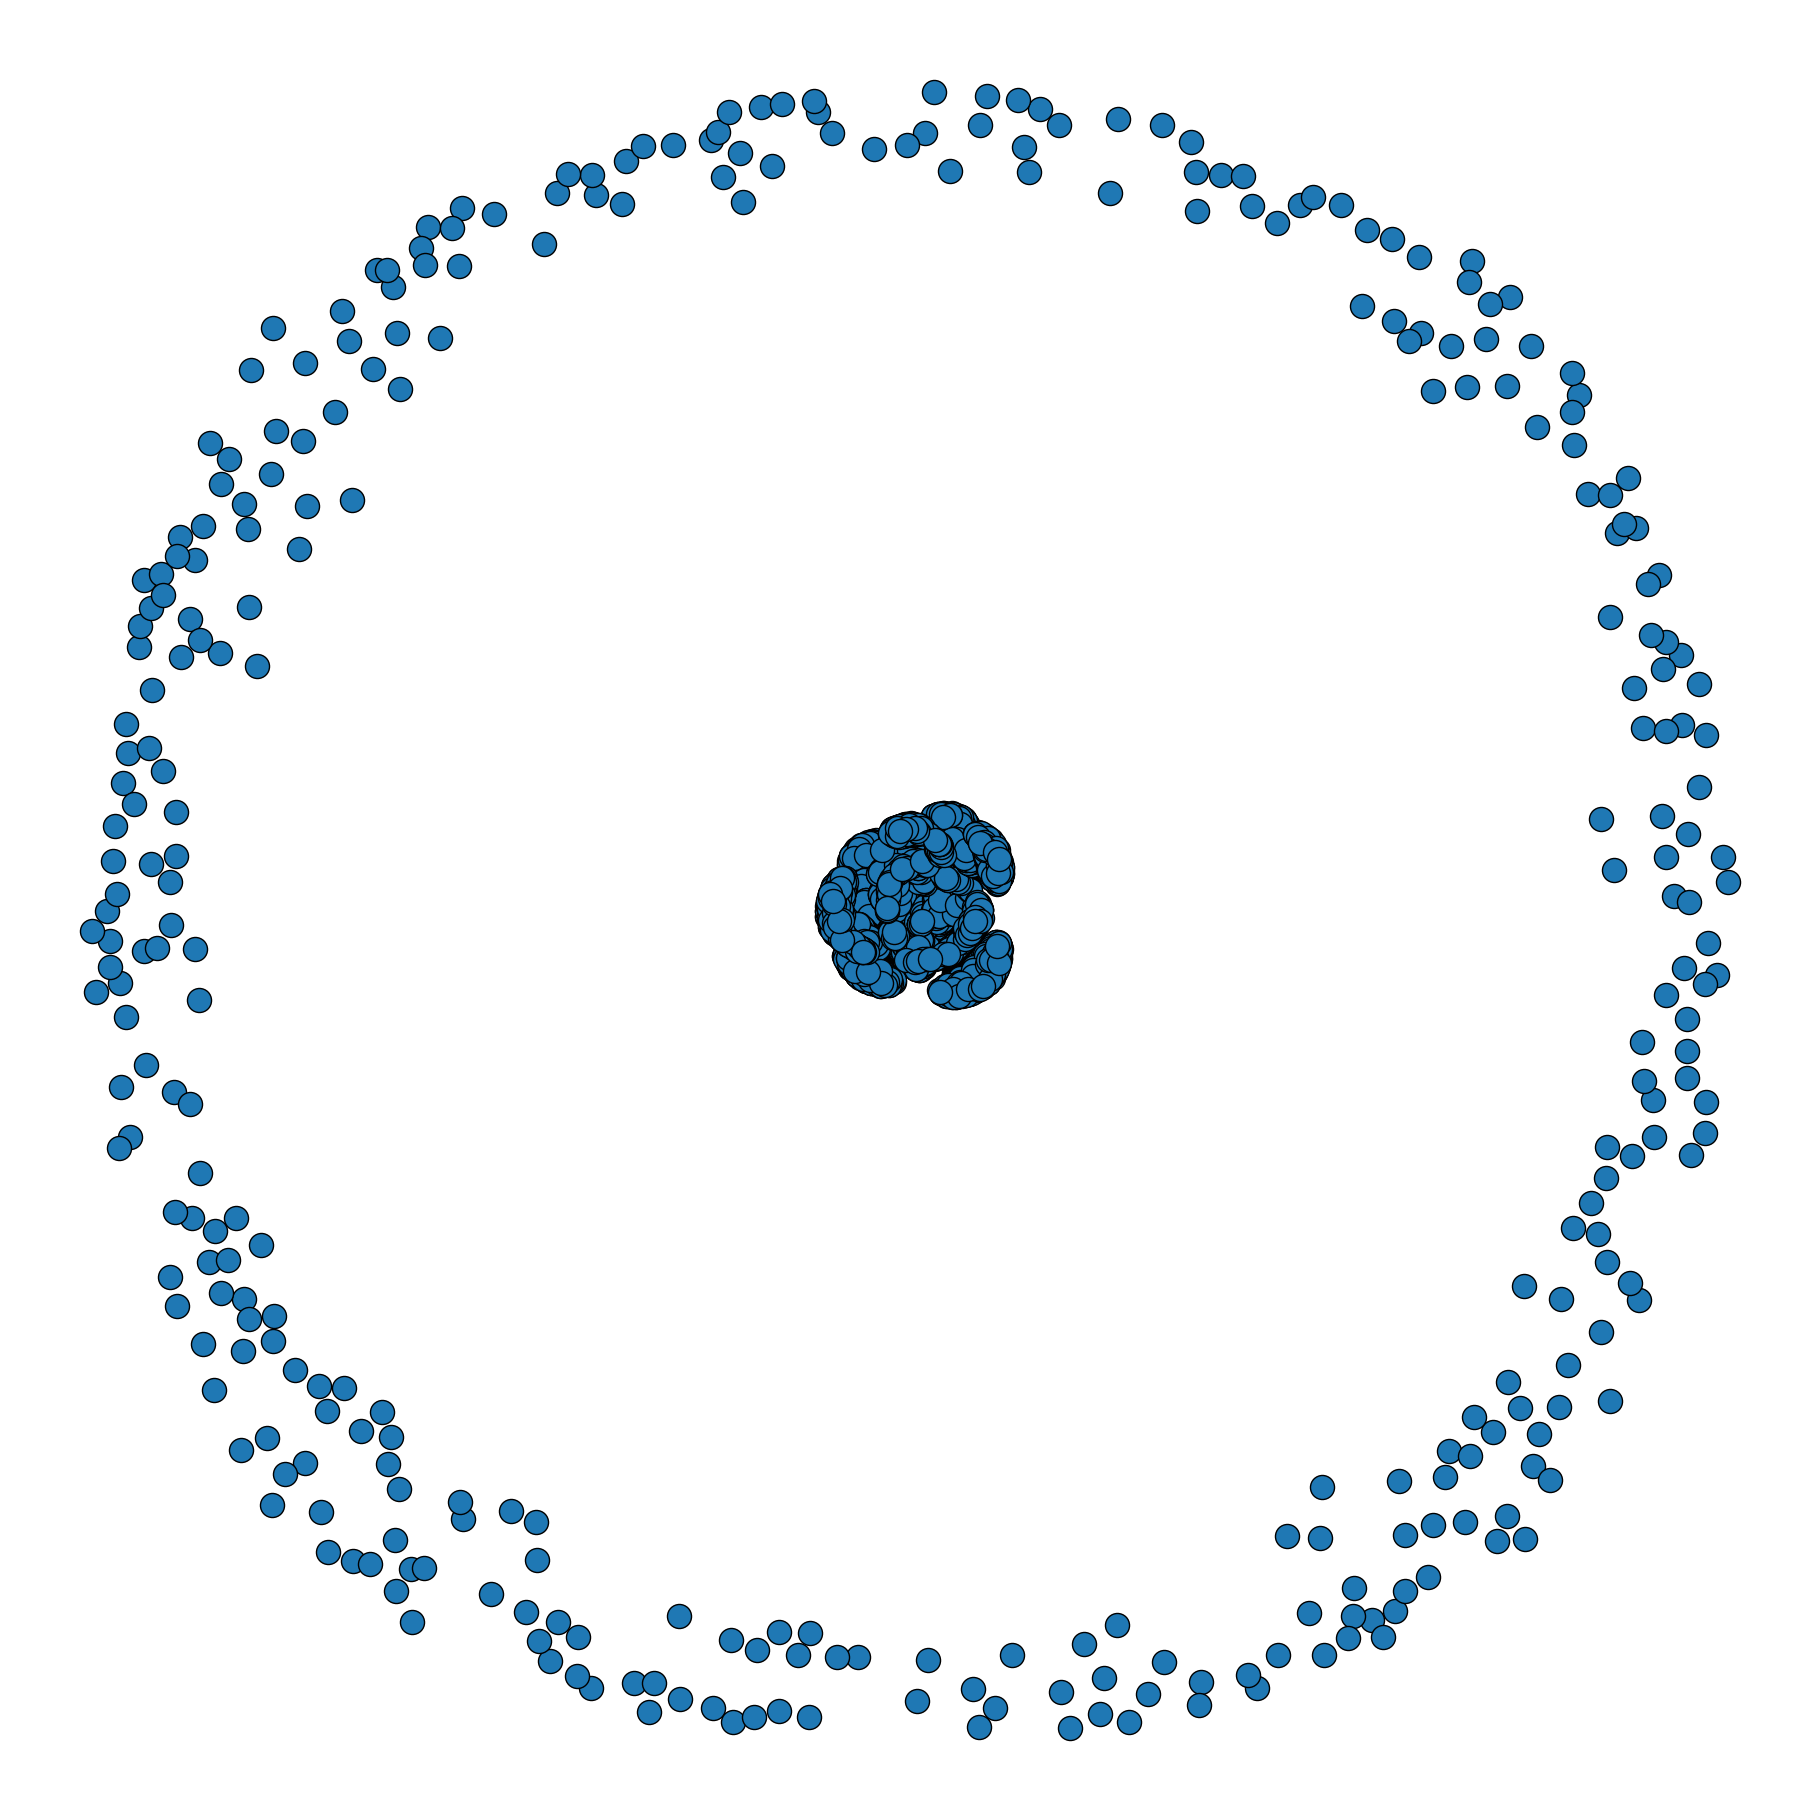

In [54]:
plt.figure(figsize=(18,18))
nx.draw(Gb_train)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black

In [55]:
edge_subset_size = len(list(edge_subset))
print("Number of edges deleted : %d" % edge_subset_size)
print("Number of edges remaining : %d" % (m - edge_subset_size))

Number of edges deleted : 1629
Number of edges remaining : 6519


[Top](#toc)

### Jaccard Coefficient <a name="jaccard"></a>

In [56]:
%%time
# Make prediction using Jaccard Coefficient
pred_jaccard = list(nx.jaccard_coefficient(Gb_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])

fpr_jaccard, tpr_jaccard, _ = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = round(roc_auc_score(label_jaccard, score_jaccard), 4)

CPU times: total: 3min 10s
Wall time: 3min 10s


In [57]:
pred_jaccard

[('KONIEV, MRS.', 'PUPPY', 0.0),
 ('KONIEV, MRS.', 'FAYRELYTE STRONGHEAR', 0.2),
 ('KONIEV, MRS.', 'FUGUE', 0.0),
 ('KONIEV, MRS.', 'KARMA', 0.0),
 ('KONIEV, MRS.', 'TERRAX II', 0.0),
 ('KONIEV, MRS.', 'TAGAR', 0.0),
 ('KONIEV, MRS.', 'REILLY, MAVIS', 0.0),
 ('KONIEV, MRS.', 'ROGERS, CAPT. STEVEN', 0.0),
 ('KONIEV, MRS.', 'MAKO', 0.0),
 ('KONIEV, MRS.', 'NELSON, CANDACE', 0.0),
 ('KONIEV, MRS.', 'LEVIATHAN II', 0.0),
 ('KONIEV, MRS.', 'MYSTERIA', 0.0),
 ('KONIEV, MRS.', 'ROSS, EVERETT KENNET', 0.2),
 ('KONIEV, MRS.', 'BUTTERFLY', 0.0),
 ('KONIEV, MRS.', 'JEFFERSON, DR.', 0.0),
 ('KONIEV, MRS.', 'SMITH, JOE', 0.0),
 ('KONIEV, MRS.', 'MAXIMUS [INHUMAN]', 0.0),
 ('KONIEV, MRS.', 'ROCKETLAUNCHER', 0.0),
 ('KONIEV, MRS.', 'ASP II', 0.6666666666666666),
 ('KONIEV, MRS.', 'BUNYAN, PAUL', 0.0),
 ('KONIEV, MRS.', 'AUTHORITY', 0.0),
 ('KONIEV, MRS.', 'FU MANCHU', 0.0),
 ('KONIEV, MRS.', 'FLAME II', 0.0),
 ('KONIEV, MRS.', 'TAYLOR, JENNA', 0.0),
 ('KONIEV, MRS.', 'TECHNOSPIKE', 0.0),
 ('KONIEV, M

### Adamic-Adar <a name="adamic"></a>

In [58]:
%%time
# Prediction using Adamic Adar 
pred_adamic = list(nx.adamic_adar_index(Gb_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic])

# Compute the ROC AUC Score
fpr_adamic, tpr_adamic, _ = roc_curve(label_adamic, score_adamic)
auc_adamic = round(roc_auc_score(label_adamic, score_adamic), 4)

CPU times: total: 3min
Wall time: 3min


### Preferential Attachment <a name="prefatt"></a>

In [59]:
%%time
# Compute the Preferential Attachment
pred_pref = list(nx.preferential_attachment(Gb_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref])

fpr_pref, tpr_pref, _ = roc_curve(label_pref, score_pref)
auc_pref = round(roc_auc_score(label_pref, score_pref), 4)

CPU times: total: 2min 36s
Wall time: 2min 36s


### Plotting the results <a name="plotting"></a>

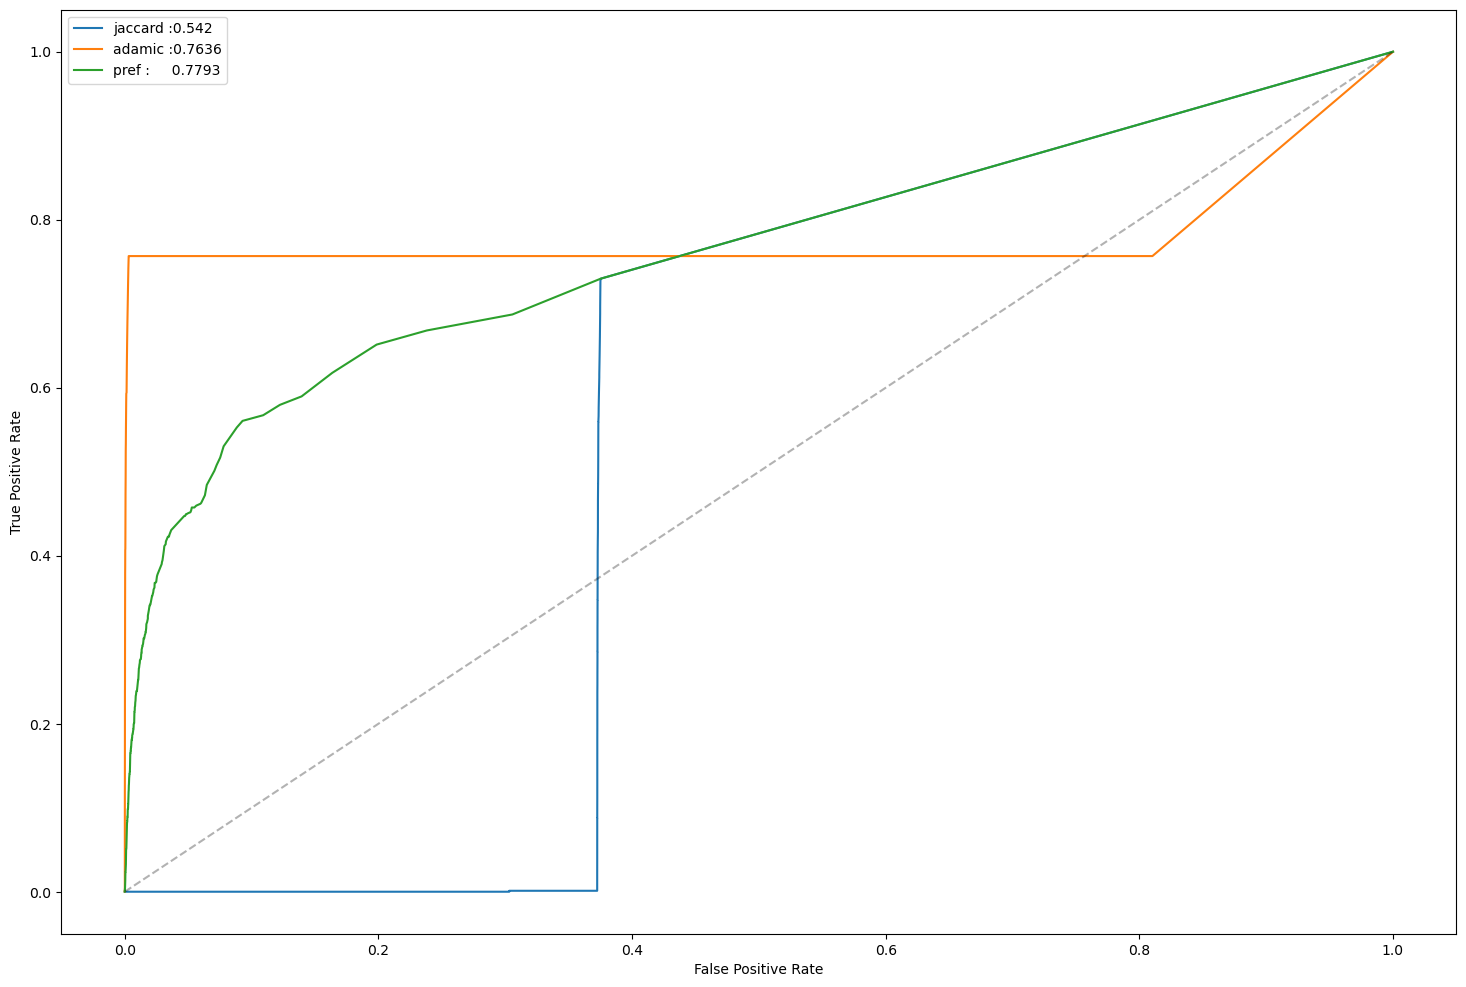

In [60]:
plt.figure(figsize=(18,12))
plt.plot(fpr_jaccard, tpr_jaccard, label="jaccard :"+str(auc_jaccard))
plt.plot(fpr_pref, tpr_pref, label="adamic :"+str(auc_adamic))
plt.plot(fpr_adamic, tpr_adamic, label="pref :     "+str(auc_pref))
plt.plot([0, 1], [0, 1], "k--", alpha = 0.3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

[Top](#toc)

## Afterthought <a name="aftertot"></a>

### Which Algo? <a name="whichalgo"></a>

Both methods show the possibility of predicting links in a network graph with predicting power in the range of 63-78%. The results aren't optimal but are respectable. The classification method dropped 7% in the accuracy against the test data to 63%, showing there is overfitting. Believe it is likely due to multicollinearity between the features. The AUC for Jaccard was subpar while Adamic seemed promising at 0.7636 but the plot was odd. Preferential Attachment performed well at 0.7793. 

Keeping in mind that both used sample dataset of 8 popular heroes, where links of these 8 heroes were extracted. The 2nd degree links where possible links between other heroes were left out. This is particularly obvious in the [network graph depicting many isolated nodes](#isolated-nodes) due to random removal of links. If there 2nd and 3rd degree links were included, the network is likely to provide more comprehensive information. 

Using link prediction in comic heroes may not be ideal compared to social network analysis. In social network, there are latent relationship between the nodes. Eg links maybe due to hobby, religion, etc. As for comics heroes, it is difficult to imagine latent relationships between the characters other than the creativity of the script writers.

### What's next? <a name="whatnext"></a>

1) Use the full dataset rather than the extracted sample for further experimentation. The outcome may yield better results where 2nd and 3rd degree links are present. However computational requirement will explode. 

2) Further finetune the classification parameters.

3) Look into Graph Neural Network.

@End